# 📘 Title & Overview

# AdaBoost — Adaptive Boosting
**What you'll learn**
- Intuition and math behind AdaBoost 🎯  
- Step-by-step algorithm and update equations (clean LaTeX) ✍️  
- Visual example on a 2D toy dataset (showing sample-weighting) 🧪  
- Use of `sklearn.ensemble.AdaBoostClassifier` ✅  
- Implementation **from scratch** with a simple Decision Stump weak learner 🛠️  
- Plots: decision boundaries, training error vs iterations, sample weights visualization 📈

*Tip:* Run cells top → bottom in a Jupyter notebook.


# 🔎 Intuition (Short)

AdaBoost combines many **weak learners** into a **strong learner** by training them sequentially. Each new weak learner focuses more on examples the previous learners got wrong by using a weighted training set. The final prediction is a weighted vote of the weak learners.

- Weak learners: slightly-better-than-random classifiers (commonly decision stumps).  
- AdaBoost adaptively updates sample weights and assigns each weak learner a weight (α) based on its accuracy.


# 🧮 Core equations (LaTeX)

**Notation**
- Training set: $ \{(x_i, y_i)\}_{i=1}^n $ with $ y_i \in \{-1, +1\} $.
- Weak learner $ h_t(x) \in \{-1, +1\} $.
- Sample weights at iteration $t$: $w_i^{(t)}$ (normalized so $\sum_i w_i^{(t)} = 1$).
- Weighted error of $h_t$:
$$
\varepsilon_t = \sum_{i=1}^n w_i^{(t)} \, \mathbf{1}[h_t(x_i) \ne y_i]
$$

**Learner weight (importance):**
$$
\alpha_t = \frac{1}{2} \ln\left(\frac{1 - \varepsilon_t}{\varepsilon_t}\right)
$$

**Update rule for sample weights:**
$$
w_i^{(t+1)} = \frac{w_i^{(t)} \exp\left(-\alpha_t y_i h_t(x_i)\right)}{Z_t}
$$
where \(Z_t\) is a normalization constant:
$$
Z_t = \sum_{j=1}^n w_j^{(t)} \exp\left(-\alpha_t y_j h_t(x_j)\right)
$$

**Final strong classifier:**
$$
H(x) = \operatorname{sign}\left( \sum_{t=1}^T \alpha_t \, h_t(x) \right)
$$

> Note: When \(\varepsilon_t = 0\) or \(1\), \(\alpha_t\) goes to \(\infty\) or \(-\infty\). In practice we clip \(\varepsilon_t\) to avoid division by zero.


# ⚙️ What AdaBoost actually does (step-by-step)

1. Initialize weights \(w_i^{(1)} = 1/n\).  
2. For t = 1..T:
   - Train weak learner \(h_t\) on training data using weights \(w^{(t)}\).
   - Compute weighted error \(\varepsilon_t\).
   - Compute learner weight \(\alpha_t = 0.5 \ln((1-\varepsilon_t)/\varepsilon_t)\).
   - Update sample weights: increase weights for misclassified examples, decrease for correctly classified ones.
   - Normalize weights.
3. Final prediction is sign of weighted sum of weak learners: \( \operatorname{sign}(\sum \alpha_t h_t(x)) \).

Intuition: misclassified points receive larger weights → next learner tries harder on them.


In [1]:
# — Python setup: imports & helper functions
# Run this cell first to import libs used by the rest of the notebook.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# for reproducibility
RND = 42
np.random.seed(RND)


#  🧪 Create a 2D toy dataset (visual)  

We build a simple 2-feature classification set to visualize the effect of AdaBoost.


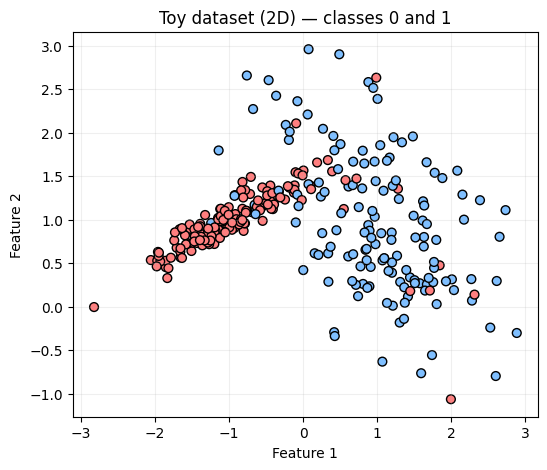

In [2]:
# Create and show toy dataset

X, y = make_classification(
    n_samples=300, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=1.0, flip_y=0.10, random_state=RND
)
# Convert labels from {0,1} to {-1,+1} for algorithm math
y_pm = np.where(y == 0, -1, 1)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['#ff7f7f','#7fbfff']), edgecolor='k', s=40)
plt.title("Toy dataset (2D) — classes 0 and 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(alpha=0.2)
plt.show()


# 🎯 Visualize sample weights (initially uniform)

We will visualize sample point sizes proportional to their weights later. Initially all weights = 1/n.


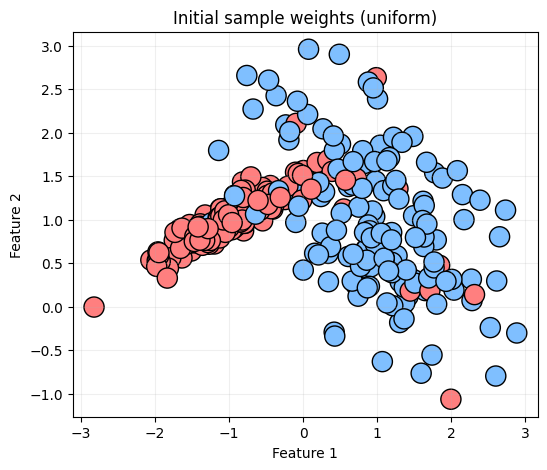

In [3]:
#  initial weights visualization

n = X.shape[0]
w = np.ones(n) / n

plt.figure(figsize=(6,5))
sizes = 200 * (w / w.max())  # scale for plotting
plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['#ff7f7f','#7fbfff']), s=sizes+10, edgecolor='k')
plt.title("Initial sample weights (uniform)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(alpha=0.2)
plt.show()


#  🛠️ Decision stump (weak learner) implemented from scratch

We'll implement a simple Decision Stump:
- It picks one feature and a threshold that minimizes weighted classification error.
- Prediction is either {-1,+1}.


In [4]:
#  DecisionStump class (from scratch)

class DecisionStump:
    """A simple decision stump classifier for AdaBoost (binary labels -1, +1)."""
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1  # determines direction of inequality
        self.alpha = None

    def fit(self, X, y, sample_weights):
        n_samples, n_features = X.shape
        best_err = float('inf')
        # try all features and candidate thresholds
        for feature in range(n_features):
            values = np.unique(X[:, feature])
            # candidate thresholds: midpoints between consecutive values
            thresholds = (values[:-1] + values[1:]) / 2.0 if len(values) > 1 else values
            if len(thresholds) == 0:
                thresholds = values
            for thr in thresholds:
                for polarity in [1, -1]:
                    # prediction: polarity * (x_feature < thr) -> +1 or -1
                    pred = np.ones(n_samples)
                    if polarity == 1:
                        pred[X[:, feature] < thr] = -1
                    else:
                        pred[X[:, feature] > thr] = -1
                    err = np.sum(sample_weights[pred != y])
                    if err < best_err:
                        best_err = err
                        self.feature_index = feature
                        self.threshold = thr
                        self.polarity = polarity
        return self

    def predict(self, X):
        n_samples = X.shape[0]
        pred = np.ones(n_samples)
        if self.polarity == 1:
            pred[X[:, self.feature_index] < self.threshold] = -1
        else:
            pred[X[:, self.feature_index] > self.threshold] = -1
        return pred


#  AdaBoost from scratch (using DecisionStump)

We'll implement an AdaBoost class with:
- `fit(X, y, T)` -> trains T weak learners
- `predict(X)` -> final sign of weighted sum
- `staged_predict(X)` -> predictions after each iteration (useful for plots)


In [5]:
# Cell 13 — AdaBoostScratch class

class AdaBoostScratch:
    def __init__(self, T=50):
        self.T = T
        self.stumps = []
        self.alphas = []

    def fit(self, X, y, verbose=False):
        n = X.shape[0]
        # initialize weights
        w = np.ones(n) / n
        self.stumps = []
        self.alphas = []

        for t in range(self.T):
            stump = DecisionStump()
            stump.fit(X, y, w)
            pred = stump.predict(X)

            # compute weighted error
            err = np.sum(w[pred != y])
            # clip err to avoid division by zero or log of zero
            err = np.clip(err, 1e-10, 1 - 1e-10)

            # compute alpha
            alpha = 0.5 * np.log((1 - err) / err)
            stump.alpha = alpha

            # update weights
            w = w * np.exp(-alpha * y * pred)
            w = w / np.sum(w)

            # save
            self.stumps.append(stump)
            self.alphas.append(alpha)

            if verbose and (t % 10 == 0 or t == self.T-1):
                print(f"Iter {t+1}/{self.T}: err={err:.4f}, alpha={alpha:.4f}")

        return self

    def predict_scores(self, X):
        # return raw score sum alpha * h(x)
        scores = np.zeros(X.shape[0])
        for stump, alpha in zip(self.stumps, self.alphas):
            scores += alpha * stump.predict(X)
        return scores

    def predict(self, X):
        scores = self.predict_scores(X)
        return np.sign(scores)

    def staged_scores(self, X):
        # yields cumulative scores after each iteration
        scores = np.zeros(X.shape[0])
        for stump, alpha in zip(self.stumps, self.alphas):
            scores += alpha * stump.predict(X)
            yield scores.copy()


#  Train AdaBoost (scratch) on toy dataset and show training accuracy / weights visualization

We'll train for a moderate number of iterations (e.g., T=30), then visualize:
- sample weights after last iteration (size ~ weight)
- training accuracy


Iter 1/30: err=0.1476, alpha=0.8767
Iter 11/30: err=0.4408, alpha=0.1189
Iter 21/30: err=0.4450, alpha=0.1104
Iter 30/30: err=0.4564, alpha=0.0874


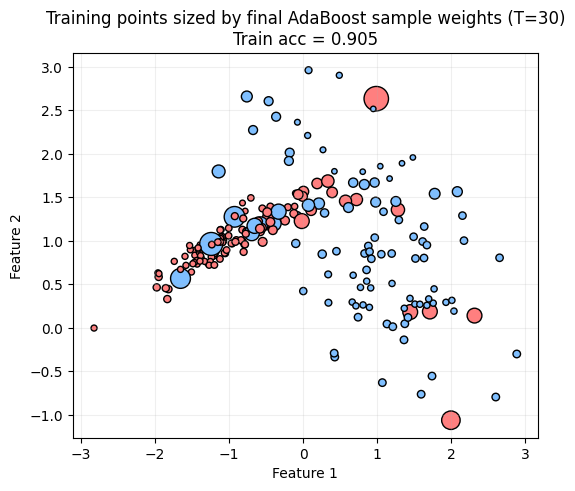

In [6]:
# Cell 15 — Train and visualize

# split
X_train, X_test, y_train, y_test = train_test_split(X, y_pm, test_size=0.3, random_state=RND)

T = 30
model_scratch = AdaBoostScratch(T=T)
model_scratch.fit(X_train, y_train, verbose=True)

# training accuracy
y_train_pred = model_scratch.predict(X_train)
train_acc = np.mean(y_train_pred == y_train)

# compute final sample weights by simulating updates to plot sizes
n_train = X_train.shape[0]
w = np.ones(n_train) / n_train
for stump, alpha in zip(model_scratch.stumps, model_scratch.alphas):
    pred = stump.predict(X_train)
    w = w * np.exp(-alpha * y_train * pred)
    w = w / np.sum(w)

plt.figure(figsize=(6,5))
sizes = 300 * (w / w.max())
plt.scatter(X_train[:,0], X_train[:,1], c=(y_train==1), cmap=ListedColormap(['#ff7f7f','#7fbfff']), s=sizes+10, edgecolor='k')
plt.title(f"Training points sized by final AdaBoost sample weights (T={T})\nTrain acc = {train_acc:.3f}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(alpha=0.2)
plt.show()


# 🔍 Plot training error vs boosting iterations (scratch)

We'll compute the training error after each iteration using staged predictions from our scratch model.


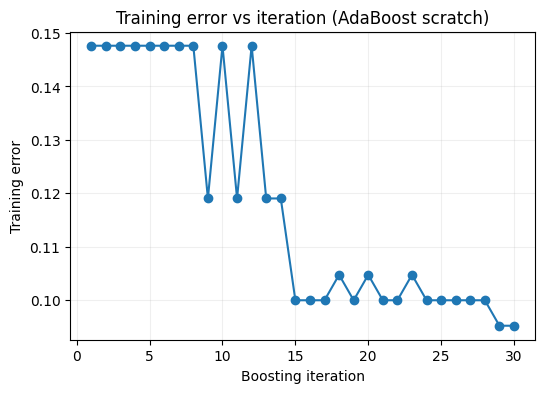

In [7]:
# training error over iterations (scratch)

errors = []
for scores in model_scratch.staged_scores(X_train):
    preds = np.sign(scores)
    errors.append(np.mean(preds != y_train))

plt.figure(figsize=(6,4))
plt.plot(range(1, len(errors)+1), errors, marker='o')
plt.xlabel("Boosting iteration")
plt.ylabel("Training error")
plt.title("Training error vs iteration (AdaBoost scratch)")
plt.grid(alpha=0.2)
plt.show()


# 🧾 Use `sklearn` AdaBoost (quick demo)

We'll train `sklearn.ensemble.AdaBoostClassifier` with `DecisionTreeClassifier(max_depth=1)` stumps and compare performance.


In [12]:
# sklearn AdaBoost training & comparison

sk_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=RND),   # FIXED
    n_estimators=T,
    algorithm="SAMME",
    random_state=RND
)

# sklearn expects labels in {0,1}, so convert:
y_train_skl = np.where(y_train == -1, 0, 1)
y_test_skl = np.where(y_test == -1, 0, 1)

sk_model.fit(X_train, y_train_skl)

# predictions
sk_train_pred = sk_model.predict(X_train)
sk_test_pred = sk_model.predict(X_test)

sk_train_acc = accuracy_score(y_train_skl, sk_train_pred)
sk_test_acc = accuracy_score(y_test_skl, sk_test_pred)

print(f"sklearn AdaBoost train acc = {sk_train_acc:.4f}, test acc = {sk_test_acc:.4f}")
print(f"scratch AdaBoost train acc = {train_acc:.4f}")

# quick comparison on test set using scratch (convert y_test to -1/+1)
y_test_pred_scratch = model_scratch.predict(X_test)
scratch_test_acc = np.mean(y_test_pred_scratch == y_test)
print(f"scratch AdaBoost test acc = {scratch_test_acc:.4f}")


sklearn AdaBoost train acc = 0.8762, test acc = 0.9444
scratch AdaBoost train acc = 0.9048
scratch AdaBoost test acc = 0.9556


d:\Python\ml-basics\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


# 🗺️ Decision boundary visualization (sklearn & scratch)

We'll visualize the decision boundary for both models to compare how the ensemble partitions the space.


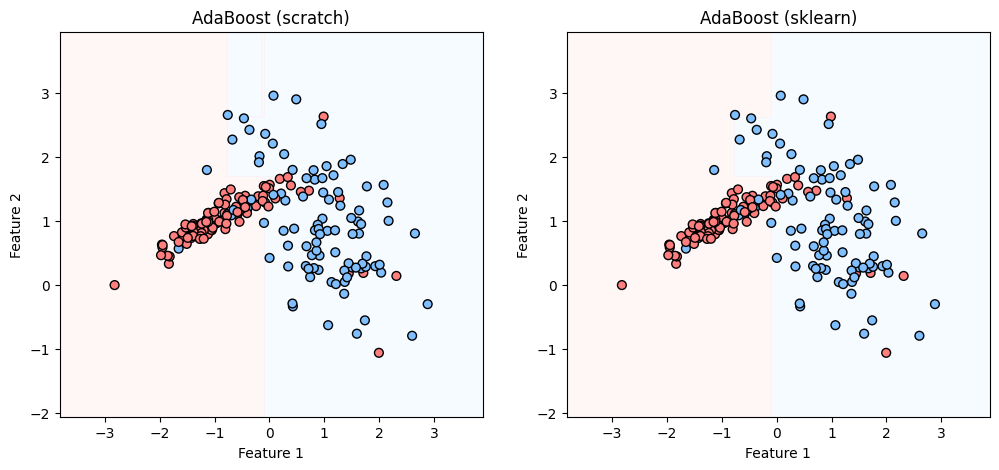

In [13]:
# Cell 21 — Decision boundary function and plotting

def plot_decision_boundary(clf_predict, X, y, ax, title="Decision boundary"):
    # clf_predict: function that accepts X_grid and returns labels in {-1,+1} or {0,1}
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf_predict(grid)
    # make sure labels to plot are 0/1
    if np.unique(Z).min() == -1:
        Z = np.where(Z == -1, 0, 1)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25, levels=[-0.1,0.5,1.1], cmap=ListedColormap(['#ffdddd','#ddf0ff']))
    ax.scatter(X[:,0], X[:,1], c=(y==1), cmap=ListedColormap(['#ff7f7f','#7fbfff']), edgecolor='k', s=40)
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_decision_boundary(lambda Xg: model_scratch.predict(Xg), X_train, y_train, axes[0], title="AdaBoost (scratch)")
plot_decision_boundary(lambda Xg: sk_model.predict(Xg), X_train, np.where(y_train==1,1,0), axes[1], title="AdaBoost (sklearn)")
plt.show()


# 🚦 Practical tips & notes

- **Weak learners**: Decision stumps (depth=1 trees) are common. You can use deeper trees but may overfit.  
- **SAMME vs SAMME.R**: `SAMME.R` uses the real-valued estimator (probability estimates) and often converges faster; `SAMME` uses discrete predictions.  
- **Number of estimators (T)**: tune via validation; more estimators reduce bias but can overfit noisy data.  
- **Outliers & noise**: AdaBoost focuses on hard examples; if they are noisy/outliers, AdaBoost may overfit them. Consider using early stopping or regularization.  
- **Label encoding**: For math we used \{-1,+1\}; `sklearn` uses \{0,1\}.


# ✅ Summary & final remarks

- AdaBoost adaptively changes sample weights to focus learning on hard examples.  
- Final model is a weighted sum of weak learners.  
- It's simple to use with `sklearn` and educational to build from scratch (Decision Stump + weight updates).  
- Visualizations of sample weights and decision boundaries are key to understanding how AdaBoost focuses on mistakes.

If you'd like, I can:
- Add animation showing how the boundary evolves iteration-by-iteration, or  
- Replace the scratch decision stump with a stump implemented using `sklearn`'s `DecisionTreeClassifier(max_depth=1)` to speed up training.  

Tell me which extra visualization or extension you'd like next! ✨
